In [ ]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb



# 修正したモデルから卒論時に集計したデータを作成する

1. 表

| ベンチマーク名 | 平均誤差率(%) | コスト比(%) |
|---------|----------|---------|


2. 表

| ベンチマーク名 | 採用割合(最大MAPE(%), 最小MAPE(%)) |
|---------|----------------------------|
|         | モデル(1), モデル(2), ...        |


* 平均誤差率：大規模実行時の関数コール回数との比較
* MAPE：トレーニングデータとの比較

In [ ]:
plt.figure(figsize=(4, 3))
plt.xlabel("使用したプロファイル数")
plt.ylabel("平均誤差率(%)")

In [ ]:
# pd.get_option("display.max_columns")
# pd.get_option("display.max_rows")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [ ]:
# benchmarksからbt, spを除外する
benchmarks = [benchmark for benchmark in benchmarks if benchmark !=
              'bt' and benchmark != 'sp']
# pandasのDFをprintした時の幅を広げる
pd.set_option('display.width', 100)

In [ ]:
dictTmp = returnDictForPlotPerNumOfUsedData(Benchmark=benchmarks, fix="Class", benchmarkClass=[
    "A", "B", "C", "D"], FixedProcess=64, Processes=[1, 2, 4, 8, 16, 32, 64, 128, 256], FixedBenchmarkClass="C")

In [ ]:
pd.options.display.float_format = '{:.4g}'.format

tmpDF = pd.DataFrame()
for benchmark in benchmarks:
    listToLearn = [1, 2, 4, 8, 16, 32, 64, 128]
    listToPredict = [256]
    benchmark_x = dictTmp[benchmark]["x"]
    benchmark_y = dictTmp[benchmark]["y"]
    index = benchmark_x.index(len(listToLearn))
    MAPE = benchmark_y[index]
    relativeCost = returnRelativeCost(benchmark=benchmark, variablesToLearn=listToLearn,
                                      variablesToPredict=listToPredict, fixedClassOrProcess="Class", fixed="C")
    dictRowData = {"ベンチマーク名": benchmark.upper(), "平均絶対誤差率[％]": MAPE, "相対コスト[％]": relativeCost}
    iDF = pd.DataFrame.from_dict(dictRowData, orient='index').T
    tmpDF = tmpDF.append(iDF)
tmpDFMean = tmpDF.mean()
type(tmpDFMean)
print(tmpDF.to_latex(index=False))

In [ ]:
# dictTmp

plt.figure(figsize=(5.72, 4),dpi=200)
for benchmark in list(dictTmp.keys()):
    x = dictTmp[benchmark]["x"]
    y = dictTmp[benchmark]["y"]
    plt.plot(x, y, marker='o', label=benchmark.upper())
    plt.legend()
    plt.xlabel("使用したプロファイル数")
    plt.ylabel("平均絶対誤差率[％]")

In [ ]:
plt.figure(figsize=(5.72, 4),dpi=200)

# Extra-PでfixProcessデータを入力して出力したモデルの図時
plot_x = np.linspace(0.8, 256, 500)
# -3590464.6990329633 + 3759195.349891038 * p^(1/4)
plot_y = []
for x in plot_x:
    plot_y.append(2286768.3333333326 + 301997.61904761934 * math.log2(x)**(1))
plt.plot(plot_x, plot_y, label="ExtraP")

x = [1, 2, 4, 8, 16, 32, 64, 128]
y = [1984770.0, 2263540.0, 2821070.0, 3936140.0, 3936140.0, 3936140.0, 3936140.0, 3936140.0]
x = np.array(x).reshape(-1,1)
y = np.array(y).reshape(-1, 1)
plt.scatter(x, y, marker="o", label="予測に用いた関数コール回数")
plot_x = np.array(plot_x).reshape(-1, 1)
x_target = [256]
y_target = [3936140]
plt.scatter(x_target, y_target, marker="o", label="予測したい関数コール回数の実測値")

benchmarkName = "CG"
functionName = "ICNVRT"

# 線形モデル
# 対数モデル

# 反比例モデル
modelIpMk2 = ModelIp_mk2(train_x=x, train_y=y, target_x=x_target, target_y=y_target, benchmark_name=benchmarkName, function_name=functionName)
modelIpMk2.calc_lr()
plot_y_IpMk2 = modelIpMk2.predict(plot_x)
plt.plot(plot_x, plot_y_IpMk2, label="反比例モデル")
# 線形飽和モデル
modelBranchMk2 = ModelBranch_mk2(train_x=x, train_y=y, target_x=x_target, target_y=y_target, benchmark_name=benchmarkName, function_name=functionName)
modelBranchMk2.calc_lr()
plot_y_BranchMk2 = modelBranchMk2.predict(plot_x)
plt.plot(plot_x, plot_y_BranchMk2, label="線形飽和モデル")
# # 線形モデル
# model_lin = ModelLin(x, y, "CG", "ICNVRT", test_ratio=0)
# model_lin.calc_lr()
# plot_y_lin = model_lin.predict(plot_x)
# plt.plot(plot_x, plot_y_lin, label="線形モデル")
# # 対数モデル
# model_log10 = ModelLog10(x, y, "CG", "ICNVRT", test_ratio=0)
# model_log10.calc_lr()
# plot_y_log10 = model_log10.predict(plot_x)
# plt.plot(plot_x, plot_y_log10, label="対数モデル")
# # 反比例モデル
# model_ip = ModelIP(x, y, "CG", "ICNVRT", test_ratio=0)
# model_ip.calc_lr()
# plot_y_ip = model_ip.predict(plot_x)
# plt.plot(plot_x, plot_y_ip, label="反比例モデル")
# # 線形飽和モデル
# model_branch = ModelBranch(x, y, "CG", "ICNVRT", test_ratio=0)
# model_branch.calc_lr()
# plot_y_branch = model_branch.predict(plot_x)
# plt.plot(plot_x, plot_y_branch, label="線形飽和モデル")
# 凡例の表示
plt.legend()
# 軸ラベルの設定
plt.ylabel("関数コール回数")
plt.xlabel("実行コア数")

plt.scatter(x, y, marker="o")

In [ ]:
# 実際にプロットする


# print(f"fix={fix}, benchmarkClasses={benchmarkClasses}, fixedProcess={fixedProcess}, Processes={processes}, FixedBenchmarkClass={fixedBenchmarkClass}")
# print(f"targetNumOfProcess={targetNumOfProcess}, targetProblemSize={fixedBenchmarkClass}, fix={fix}")

# DF = returnRawDFperBenchmark(Benchmark="mg", fix="Process", benchmarkClass=["A", "B", "C", "D"], Processes=[
#                              1, 2, 4, 8, 16, 32, 64, 128, 256], FixedBenchmarkClass="B", FixedProcess=64)
# DF.dropna(how='any')
# DF

In [ ]:
%reset

In [1]:
# ipynb形式のライブラリのインポート
%run ./lib/lib.ipynb

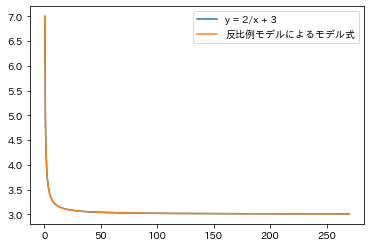

In [2]:
# 反比例モデル
# テスト用モデル式：
# y = 2/x + 3
# X軸の連続値
plotX = np.linspace(0.5, 270, 500)
plt.figure()
plotY = 2/plotX + 3
plt.plot(plotX, plotY, label="y = 2/x + 3")
# モデルの構築
_modelIp = ModelIp(trainX=plotX, trainY=plotY, targetX=[], targetY=[])
_modelIp.calcLr()
predictedY = _modelIp.predict(plotX)
plt.plot(plotX, predictedY, label="反比例モデルによるモデル式")
plt.legend()

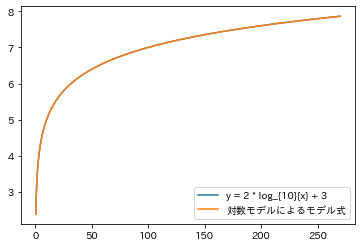

In [3]:
# 対数モデル
# テスト用モデル式：
# y = 2 * log_{10}{x} + 3
# X軸の連続値
plotX = np.linspace(0.5, 270, 500)
plt.figure()
plotY = 2 * np.log10(plotX) + 3
plt.plot(plotX, plotY, label="y = 2 * log_{10}{x} + 3")
# モデルの構築
_modelLog10 = ModelLog10(trainX=plotX, trainY=plotY, targetX=[], targetY=[])
_modelLog10.calcLr()
predictedY = _modelLog10.predict(plotX)
plt.plot(plotX, predictedY, label="対数モデルによるモデル式")
plt.legend()

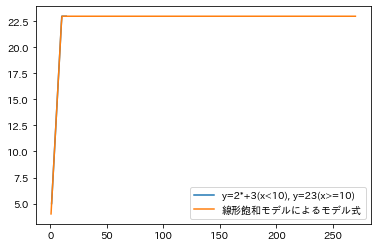

In [4]:
# 線形飽和モデル
# テスト用モデル式1：
# y = 2x + 3 (x < 10)
#     23     (x >= 10)
# テスト用モデル式2：
# y = 2x + 3
# X軸の値
plotXForBranch = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
# Y軸の値
plotYForBranch = [5,7,9,11,13,15,17,19,21,23,23,23,23,23]
plt.figure()
plt.plot(plotXForBranch, plotYForBranch, label="y=2*+3(x<10), y=23(x>=10)")
# モデルの構築
_modelBranch = ModelBranch(trainX=plotXForBranch, trainY=plotYForBranch, targetX=[], targetY=[])
_modelBranch.calcLr()
predictedY = _modelBranch.predict(plotX)
plt.plot(plotX, predictedY, label="線形飽和モデルによるモデル式")
plt.legend()

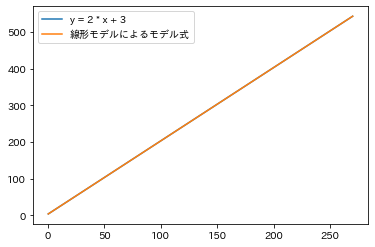

In [5]:
# 線形モデル
# テスト用モデル式：
# y = 2x + 3
# X軸の連続値
plotX = np.linspace(0.5, 270, 500)
plt.figure()
plotY = 2 * plotX + 3
plt.plot(plotX, plotY, label="y = 2 * x + 3")
# モデルの構築
_modelLin = ModelLin(trainX=plotX, trainY=plotY, targetX=[], targetY=[])
_modelLin.calcLr()
predictedY = _modelLin.predict(plotX)
plt.plot(plotX, predictedY, label="線形モデルによるモデル式")
plt.legend()